# Phase 1 Reranking Comparison

Applies cross-encoder reranking on top of **existing Phase 1 experiment results**.
Reuses the exact same queries, vector search candidates, and ground truth from the Phase 1 run.

This notebook does **not** generate new queries or run new searches — it loads the saved
Phase 1 results and only adds the reranking step to measure its isolated impact on retrieval quality.

In [2]:
# Cell 1 — Setup & Imports
import os
from pathlib import Path

from memory_retrieval.search.reranker import Reranker
from memory_retrieval.memories.schema import FIELD_SITUATION, FIELD_DISTANCE, FIELD_RERANK_SCORE
from memory_retrieval.experiments.metrics import compute_metrics
from memory_retrieval.infra.io import load_json, save_json
from memory_retrieval.infra.runs import (
    create_run, get_latest_run, get_run, list_runs, update_run_status,
    PHASE1, PHASE2,
)

# Find project root by walking up to pyproject.toml
PROJECT_ROOT = Path.cwd()
while not (PROJECT_ROOT / "pyproject.toml").exists():
    if PROJECT_ROOT == PROJECT_ROOT.parent:
        raise RuntimeError("Could not find project root (pyproject.toml)")
    PROJECT_ROOT = PROJECT_ROOT.parent
os.chdir(PROJECT_ROOT)

print(f"Project root: {PROJECT_ROOT}")
print("Imports OK.")

Project root: /Users/mayk/Projects/private/crm-memory-retrieval-research
Imports OK.


In [3]:
# Cell 2 — Configuration

# Reranking configuration
RERANK_TOP_N = 4          # Final results after reranking
DISTANCE_THRESHOLD = 1.1  # For pre-rerank metrics (must match Phase 1)

# Phase 1 run selection (source of results, DB, and test cases)
# To see available runs: print(list_runs(PHASE1))
# To select specific run: PHASE1_RUN = get_run(PHASE1, "run_20260208_143022")
PHASE1_RUN = get_latest_run(PHASE1)

# Derived paths from Phase 1
PHASE1_RESULTS_DIR = PHASE1_RUN / "results"
phase1_result_files = sorted(PHASE1_RESULTS_DIR.glob("*.json"))

print("Configuration:")
print(f"  Phase 1 run: {PHASE1_RUN.name}")
print(f"  Phase 1 results dir: {PHASE1_RESULTS_DIR}")
print(f"  Phase 1 result files: {len(phase1_result_files)}")
print(f"  Rerank top-n: {RERANK_TOP_N}")
print(f"  Distance threshold: {DISTANCE_THRESHOLD}")

if not phase1_result_files:
    print("\nERROR: No Phase 1 result files found. Run phase1.ipynb first.")

Configuration:
  Phase 1 run: run_legacy
  Phase 1 results dir: data/phase1/runs/run_legacy/results
  Phase 1 result files: 11
  Rerank top-n: 4
  Distance threshold: 1.1


## Step 1 — Load Phase 1 Results & Initialize Reranker

Load existing Phase 1 experiment results (queries + vector search candidates).
Initialize the cross-encoder reranker (`bge-reranker-v2-m3`).

In [4]:
# Cell 4 — Load Phase 1 Results & Initialize Reranker

# Load all Phase 1 experiment results
# When multiple results exist per test case, keep the latest experiment
phase1_by_tc: dict[str, dict] = {}
for f in phase1_result_files:
    data = load_json(str(f))
    tc_id = data.get("test_case_id", "?")
    if tc_id not in phase1_by_tc or data.get("experiment_id", "") > phase1_by_tc[tc_id].get("experiment_id", ""):
        phase1_by_tc[tc_id] = data

print(f"Loaded {len(phase1_by_tc)} unique test case results from Phase 1\n")
for tc_id, data in sorted(phase1_by_tc.items()):
    gt_count = data.get("ground_truth", {}).get("count", 0)
    m = data.get("metrics", {})
    n_queries = len(data.get("queries", []))
    print(f"  {tc_id}: {n_queries} queries, {gt_count} GT memories, F1={m.get('f1', 0):.3f}")

# Initialize reranker
reranker = Reranker()

# Quick test to load the model
print("\nLoading reranker model (first use triggers download)...")
_ = reranker.score_pairs("test", ["test document"])
print("Reranker ready.")

Loaded 11 unique test case results from Phase 1

  tc_review_1: 9 queries, 3 GT memories, F1=0.154
  tc_review_10: 8 queries, 5 GT memories, F1=0.250
  tc_review_11: 9 queries, 4 GT memories, F1=0.195
  tc_review_2: 8 queries, 2 GT memories, F1=0.108
  tc_review_3: 8 queries, 2 GT memories, F1=0.103
  tc_review_4: 10 queries, 3 GT memories, F1=0.167
  tc_review_5: 10 queries, 5 GT memories, F1=0.227
  tc_review_6: 8 queries, 4 GT memories, F1=0.200
  tc_review_7: 8 queries, 4 GT memories, F1=0.200
  tc_review_8: 9 queries, 5 GT memories, F1=0.244
  tc_review_9: 10 queries, 4 GT memories, F1=0.200

Loading reranker model (first use triggers download)...
Loading reranker model: BAAI/bge-reranker-v2-m3...


Loading weights:   0%|          | 0/393 [00:00<?, ?it/s]

Reranker model loaded in 4.8s
Reranker ready.


## Step 2 — Apply Reranking to Phase 1 Results

For each Phase 1 test case result:
1. Pool and deduplicate vector search candidates from all queries
2. Compute **top-N by vector distance** baseline (apples-to-apples with reranking)
3. Rerank candidates with cross-encoder, take top-N
4. Compare both at the same N — the only difference is ranking method

No new LLM calls or vector searches — everything is reused from Phase 1.

In [5]:
# Cell 6 — Apply Reranking to Phase 1 Results

def pool_and_deduplicate(query_results: list[dict]) -> list[dict]:
    """Pool results from all queries and deduplicate by memory ID (keep best distance)."""
    best: dict[str, dict] = {}
    for qr in query_results:
        for r in qr.get("results", []):
            mid = r["id"]
            dist = r.get("distance", float("inf"))
            if mid not in best or dist < best[mid].get("distance", float("inf")):
                best[mid] = r
    return sorted(best.values(), key=lambda x: x.get("distance", 0))


# Create Phase 2 run for results
run_id, PHASE2_RUN = create_run(
    PHASE2,
    description=f"Reranking on phase1 results ({PHASE1_RUN.name}, top-{RERANK_TOP_N})",
)
RESULTS_DIR = str(PHASE2_RUN / "results")

update_run_status(PHASE2_RUN, "config", {
    "phase1_run_id": PHASE1_RUN.name,
    "reranker_model": reranker.model_name,
    "rerank_top_n": RERANK_TOP_N,
    "distance_threshold": DISTANCE_THRESHOLD,
    "mode": "reuse_phase1_results",
})

print(f"Phase 2 run: {run_id}")
print(f"Results dir: {RESULTS_DIR}\n")

all_results: list[dict] = []

# Iterate over all results from phase1
for i, (tc_id, p1_data) in enumerate(sorted(phase1_by_tc.items()), 1):
    print(f"[{i}/{len(phase1_by_tc)}] {tc_id}")

    ground_truth_ids = set(p1_data.get("ground_truth", {}).get("memory_ids", []))
    query_results = p1_data.get("queries", [])

    # Pool and deduplicate across all queries (sorted by distance, best first)
    pooled = pool_and_deduplicate(query_results)
    print(f"  Deduplicated memories count: {len(pooled)}")

    # --- Baseline: top-N by vector distance (same N as reranking) ---
    top_n_by_distance = pooled[:RERANK_TOP_N]
    distance_top_n_ids = {r["id"] for r in top_n_by_distance}
    distance_top_n_metrics = compute_metrics(distance_top_n_ids, ground_truth_ids)

    # --- Per-query reranking: rerank each query's results independently ---
    all_reranked_per_query = []
    # Iterate over all queries
    for qr in query_results:
        candidates = [
            {
                "id": r["id"],
                FIELD_SITUATION: r.get("situation", r.get(FIELD_SITUATION, "")),
                FIELD_DISTANCE: r.get("distance", 0),
                "is_ground_truth": r.get("is_ground_truth", r["id"] in ground_truth_ids),
            }
            # Itearate over all results for this query
            for r in qr.get("results", [])
        ]
        # Simple reranking, just using "situation" description - pass query string of given query result (qr) with all it's results array
        # mapped to candidates
        reranked = reranker.rerank(qr["query"], candidates, top_n=None)
        all_reranked_per_query.extend(reranked)

    # Deduplicate by best rerank score - drop information about original query string
    best_by_id: dict[str, dict] = {}
    for r in all_reranked_per_query:
        mid = r["id"]
        if mid not in best_by_id or r[FIELD_RERANK_SCORE] > best_by_id[mid][FIELD_RERANK_SCORE]:
            best_by_id[mid] = r
    all_reranked = sorted(best_by_id.values(), key=lambda x: x[FIELD_RERANK_SCORE], reverse=True)

    top_reranked = all_reranked[:RERANK_TOP_N]
    reranked_ids = {r["id"] for r in top_reranked}
    rerank_top_n_metrics = compute_metrics(reranked_ids, ground_truth_ids)

    f1_delta = rerank_top_n_metrics["f1"] - distance_top_n_metrics["f1"]
    marker = "+" if f1_delta > 0 else ""
    print(f"  Top-{RERANK_TOP_N} by distance F1={distance_top_n_metrics['f1']:.3f} | Top-{RERANK_TOP_N} by rerank F1={rerank_top_n_metrics['f1']:.3f} ({marker}{f1_delta:.3f})")

    # Build result
    result = {
        "test_case_id": tc_id,
        "source_file": p1_data.get("source_file", "unknown"),
        "phase1_experiment_id": p1_data.get("experiment_id", "unknown"),
        "model": p1_data.get("model", "unknown"),
        "prompt_version": p1_data.get("prompt_version", "unknown"),
        "reranker_model": reranker.model_name,
        "rerank_top_n": RERANK_TOP_N,
        "rerank_queries": [qr["query"] for qr in query_results],
        "distance_threshold": DISTANCE_THRESHOLD,
        "ground_truth": p1_data.get("ground_truth", {}),
        "queries": query_results,
        "pooled_candidate_count": len(pooled),
        "distance_top_n_metrics": {
            **distance_top_n_metrics,
            "n": RERANK_TOP_N,
            "ground_truth_retrieved": len(distance_top_n_ids & ground_truth_ids),
        },
        "rerank_top_n_metrics": {
            **rerank_top_n_metrics,
            "n": RERANK_TOP_N,
            "ground_truth_retrieved": len(reranked_ids & ground_truth_ids),
        },
        "reranked_results": [
            {
                "id": r["id"],
                "rerank_score": r[FIELD_RERANK_SCORE],
                "distance": r.get(FIELD_DISTANCE, 0),
                "situation": r.get(FIELD_SITUATION, ""),
                "is_ground_truth": r["id"] in ground_truth_ids,
            }
            for r in all_reranked  # Store ALL reranked (for sweep analysis)
        ],
        "distance_top_n_results": [
            {
                "id": r["id"],
                "distance": r.get("distance", 0),
                "situation": r.get("situation", r.get(FIELD_SITUATION, "")),
                "is_ground_truth": r.get("is_ground_truth", r["id"] in ground_truth_ids),
            }
            for r in top_n_by_distance
        ],
        "retrieved_ground_truth_ids": sorted(list(reranked_ids & ground_truth_ids)),
        "missed_ground_truth_ids": sorted(list(ground_truth_ids - reranked_ids)),
    }

    # Save
    Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)
    save_json(result, Path(RESULTS_DIR) / f"rerank_{tc_id}.json")
    all_results.append(result)

# Summary
successful = [r for r in all_results if "rerank_top_n_metrics" in r]
if successful:
    avg_dist = {m: sum(r["distance_top_n_metrics"][m] for r in successful) / len(successful) for m in ["recall", "precision", "f1"]}
    avg_rerank = {m: sum(r["rerank_top_n_metrics"][m] for r in successful) / len(successful) for m in ["recall", "precision", "f1"]}

    print(f"\n{'='*55}")
    print(f"SUMMARY ({len(successful)} test cases, top-{RERANK_TOP_N})")
    print(f"{'='*55}")
    print(f"{'Metric':<12} {'Top-N Distance':>15} {'Top-N Rerank':>13} {'Delta':>10}")
    print("-" * 55)
    for metric in ["recall", "precision", "f1"]:
        delta = avg_rerank[metric] - avg_dist[metric]
        print(f"{metric:<12} {avg_dist[metric]:>15.3f} {avg_rerank[metric]:>13.3f} {delta:>+10.3f}")

# Update run status
update_run_status(PHASE2_RUN, "experiment", {
    "count": len(successful),
    "avg_f1_distance_top_n": round(avg_dist["f1"], 4) if successful else 0,
    "avg_f1_rerank_top_n": round(avg_rerank["f1"], 4) if successful else 0,
    "rerank_top_n": RERANK_TOP_N,
})

Phase 2 run: run_20260210_133753
Results dir: data/phase2/runs/run_20260210_133753/results

[1/11] tc_review_1
  Pooled candidates: 36
  Top-4 by distance F1=0.857 | Top-4 by rerank F1=0.857 (0.000)
[2/11] tc_review_10
  Pooled candidates: 35
  Top-4 by distance F1=0.889 | Top-4 by rerank F1=0.667 (-0.222)
[3/11] tc_review_11
  Pooled candidates: 37
  Top-4 by distance F1=1.000 | Top-4 by rerank F1=0.750 (-0.250)
[4/11] tc_review_2
  Pooled candidates: 35
  Top-4 by distance F1=0.333 | Top-4 by rerank F1=0.000 (-0.333)
[5/11] tc_review_3
  Pooled candidates: 37
  Top-4 by distance F1=0.667 | Top-4 by rerank F1=0.667 (0.000)
[6/11] tc_review_4
  Pooled candidates: 33
  Top-4 by distance F1=0.571 | Top-4 by rerank F1=0.571 (0.000)
[7/11] tc_review_5
  Pooled candidates: 39
  Top-4 by distance F1=0.444 | Top-4 by rerank F1=0.444 (0.000)
[8/11] tc_review_6
  Pooled candidates: 36
  Top-4 by distance F1=0.500 | Top-4 by rerank F1=0.500 (0.000)
[9/11] tc_review_7
  Pooled candidates: 36
  To

## Step 3 — Results Summary Table

Per-test-case comparison: **top-N by distance** vs **top-N by rerank score** (same N, same candidates).

In [6]:
# Cell 8 — Results Summary Table

successful = [r for r in all_results if "rerank_top_n_metrics" in r]

print(f"Top-{RERANK_TOP_N} comparison: vector distance vs cross-encoder reranking\n")
print(f"{'Test Case':<25} {'Dist F1':>8} {'Rank F1':>8} {'Delta':>8} {'Dist P':>7} {'Rank P':>7} {'Dist R':>7} {'Rank R':>7}")
print("-" * 85)

for r in successful:
    name = r.get("test_case_id", "?")[:25]
    d = r["distance_top_n_metrics"]
    rk = r["rerank_top_n_metrics"]
    delta = rk["f1"] - d["f1"]
    marker = "+" if delta > 0.001 else "-" if delta < -0.001 else "="
    print(f"{name:<25} {d['f1']:>8.3f} {rk['f1']:>8.3f} {delta:>+7.3f}{marker} {d['precision']:>7.3f} {rk['precision']:>7.3f} {d['recall']:>7.3f} {rk['recall']:>7.3f}")

if successful:
    avg_d = {m: sum(r["distance_top_n_metrics"][m] for r in successful) / len(successful) for m in ["recall", "precision", "f1"]}
    avg_r = {m: sum(r["rerank_top_n_metrics"][m] for r in successful) / len(successful) for m in ["recall", "precision", "f1"]}
    delta = avg_r["f1"] - avg_d["f1"]
    marker = "+" if delta > 0 else "-" if delta < 0 else "="
    print("-" * 85)
    print(f"{'AVERAGE':<25} {avg_d['f1']:>8.3f} {avg_r['f1']:>8.3f} {delta:>+7.3f}{marker} {avg_d['precision']:>7.3f} {avg_r['precision']:>7.3f} {avg_d['recall']:>7.3f} {avg_r['recall']:>7.3f}")

    improved = sum(1 for r in successful if r["rerank_top_n_metrics"]["f1"] > r["distance_top_n_metrics"]["f1"] + 0.001)
    same = sum(1 for r in successful if abs(r["rerank_top_n_metrics"]["f1"] - r["distance_top_n_metrics"]["f1"]) <= 0.001)
    worse = sum(1 for r in successful if r["rerank_top_n_metrics"]["f1"] < r["distance_top_n_metrics"]["f1"] - 0.001)
    print(f"\nReranking helped: {improved}/{len(successful)} | Same: {same}/{len(successful)} | Hurt: {worse}/{len(successful)}")

Top-4 comparison: vector distance vs cross-encoder reranking

Test Case                  Dist F1  Rank F1    Delta  Dist P  Rank P  Dist R  Rank R
-------------------------------------------------------------------------------------
tc_review_1                  0.857    0.857  +0.000=   0.750   0.750   1.000   1.000
tc_review_10                 0.889    0.667  -0.222-   1.000   0.750   0.800   0.600
tc_review_11                 1.000    0.750  -0.250-   1.000   0.750   1.000   0.750
tc_review_2                  0.333    0.000  -0.333-   0.250   0.000   0.500   0.000
tc_review_3                  0.667    0.667  +0.000=   0.500   0.500   1.000   1.000
tc_review_4                  0.571    0.571  +0.000=   0.500   0.500   0.667   0.667
tc_review_5                  0.444    0.444  +0.000=   0.500   0.500   0.400   0.400
tc_review_6                  0.500    0.500  +0.000=   0.500   0.500   0.500   0.500
tc_review_7                  1.000    1.000  +0.000=   1.000   1.000   1.000   1.000
tc

## Step 4 — Top-N Sweep: Distance vs Reranking

Compare top-N by vector distance vs top-N by rerank score across different N values.
Shows whether reranking improves ranking quality at every cutoff point.

Top-N Sweep: Distance vs Reranking (averaged over 11 test cases)

   N   Dist P   Rank P   Dist R   Rank R  Dist F1  Rank F1  F1 Delta
----------------------------------------------------------------------
   1    0.909    0.818    0.252    0.206    0.388    0.327    -0.061
   2    0.864    0.727    0.458    0.394    0.589    0.503    -0.087
   3    0.758    0.758    0.615    0.615    0.666    0.666    +0.000
   4    0.705    0.636    0.765    0.679    0.718    0.645    -0.073
   5    0.636    0.564    0.847    0.738    0.713    0.628    -0.085
   6    0.545    0.500    0.865    0.783    0.657    0.601    -0.056
   8    0.409    0.386    0.865    0.802    0.546    0.514    -0.032
  10    0.336    0.327    0.888    0.842    0.481    0.466    -0.015
  15    0.236    0.236    0.952    0.924    0.374    0.372    -0.002
  20    0.177    0.177    0.952    0.924    0.296    0.295    -0.001


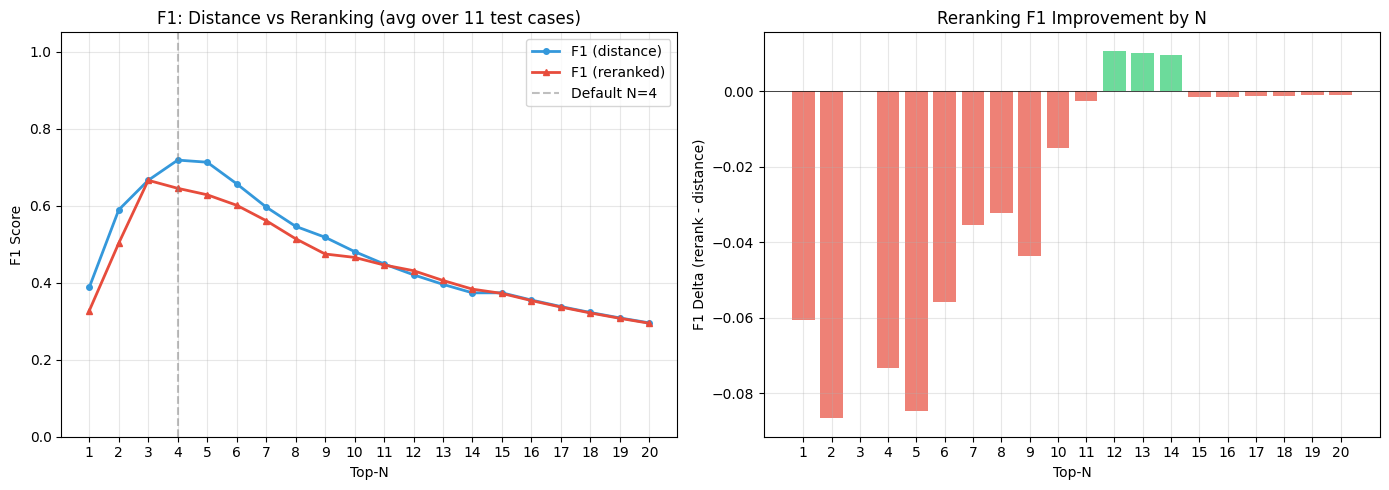

Saved: notebooks/phase2/figures/rerank_topn_sweep.png


In [7]:
# Cell 10 — Top-N Sweep: Distance vs Reranking
import matplotlib.pyplot as plt
import numpy as np

FIGURES_DIR = Path("notebooks/phase2/figures")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

all_data = all_results
n_cases = len(all_data)

if not all_data:
    print("No results found. Run Step 2 first.")
else:
    max_n = 20
    n_values = list(range(1, max_n + 1))

    # Sweep for both distance-based and rerank-based top-N
    dist_f1, rerank_f1 = [], []
    dist_p, rerank_p = [], []
    dist_r, rerank_r = [], []

    for n in n_values:
        d_f1, d_p, d_r = [], [], []
        r_f1, r_p, r_r = [], [], []

        for data in all_data:
            gt_ids = set(data.get("ground_truth", {}).get("memory_ids", []))
            gt_count = len(gt_ids)

            # Distance-based top-N (pooled is sorted by distance in queries)
            pooled = pool_and_deduplicate(data.get("queries", []))
            dist_top_n_ids = {r["id"] for r in pooled[:n]}
            d_hits = len(dist_top_n_ids & gt_ids)
            d_n = len(dist_top_n_ids)

            # Rerank-based top-N (reranked_results sorted by rerank score)
            reranked = data.get("reranked_results", [])
            rerank_top_n_ids = {r["id"] for r in reranked[:n]}
            r_hits = len(rerank_top_n_ids & gt_ids)
            r_n = len(rerank_top_n_ids)

            # Distance metrics
            p = d_hits / d_n if d_n > 0 else 0.0
            rec = d_hits / gt_count if gt_count > 0 else 0.0
            f1 = 2 * p * rec / (p + rec) if (p + rec) > 0 else 0.0
            d_p.append(p); d_r.append(rec); d_f1.append(f1)

            # Rerank metrics
            p = r_hits / r_n if r_n > 0 else 0.0
            rec = r_hits / gt_count if gt_count > 0 else 0.0
            f1 = 2 * p * rec / (p + rec) if (p + rec) > 0 else 0.0
            r_p.append(p); r_r.append(rec); r_f1.append(f1)

        dist_f1.append(np.mean(d_f1)); dist_p.append(np.mean(d_p)); dist_r.append(np.mean(d_r))
        rerank_f1.append(np.mean(r_f1)); rerank_p.append(np.mean(r_p)); rerank_r.append(np.mean(r_r))

    # Print table
    print(f"Top-N Sweep: Distance vs Reranking (averaged over {n_cases} test cases)\n")
    print(f"{'N':>4} {'Dist P':>8} {'Rank P':>8} {'Dist R':>8} {'Rank R':>8} {'Dist F1':>8} {'Rank F1':>8} {'F1 Delta':>9}")
    print("-" * 70)
    for n in [1, 2, 3, 4, 5, 6, 8, 10, 15, 20]:
        if n <= max_n:
            i = n - 1
            delta = rerank_f1[i] - dist_f1[i]
            print(f"{n:>4} {dist_p[i]:>8.3f} {rerank_p[i]:>8.3f} {dist_r[i]:>8.3f} {rerank_r[i]:>8.3f} {dist_f1[i]:>8.3f} {rerank_f1[i]:>8.3f} {delta:>+9.3f}")

    # Plot: F1 comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    ax = axes[0]
    ax.plot(n_values, dist_f1, label="F1 (distance)", color="#3498db", linewidth=2, marker="o", markersize=4)
    ax.plot(n_values, rerank_f1, label="F1 (reranked)", color="#e74c3c", linewidth=2, marker="^", markersize=4)
    ax.axvline(x=RERANK_TOP_N, color="gray", linestyle="--", alpha=0.5, label=f"Default N={RERANK_TOP_N}")
    ax.set_xlabel("Top-N")
    ax.set_ylabel("F1 Score")
    ax.set_title(f"F1: Distance vs Reranking (avg over {n_cases} test cases)")
    ax.set_xticks(n_values)
    ax.set_ylim(0, 1.05)
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot: F1 delta
    ax = axes[1]
    f1_deltas = [rerank_f1[i] - dist_f1[i] for i in range(max_n)]
    colors = ["#2ecc71" if d > 0 else "#e74c3c" for d in f1_deltas]
    ax.bar(n_values, f1_deltas, color=colors, alpha=0.7)
    ax.axhline(y=0, color="black", linewidth=0.5)
    ax.set_xlabel("Top-N")
    ax.set_ylabel("F1 Delta (rerank - distance)")
    ax.set_title("Reranking F1 Improvement by N")
    ax.set_xticks(n_values)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    fig.savefig(FIGURES_DIR / "rerank_topn_sweep.png", dpi=200, bbox_inches="tight")
    plt.show()
    print(f"Saved: {FIGURES_DIR / 'rerank_topn_sweep.png'}")

## Step 5 — Rerank Score Threshold Analysis

Mirrors the Phase 1 distance threshold analysis, but uses **rerank scores** as the filtering signal.
Instead of a fixed top-N cutoff, we sweep rerank score thresholds to find the optimal cutoff.

All metrics are **macro-averaged**: computed per test case, then averaged.
Within each test case, candidates are deduplicated by memory ID (best distance), then reranked.

Experiments: 11 test cases
GT observations:     41 (unique — each memory is GT in exactly 1 test case)
Non-GT observations: 355

GT rerank score range:     [0.0007, 0.9999]
Non-GT rerank score range: [0.0000, 0.8378]
GT mean: 0.5695, median: 0.6360
Non-GT mean: 0.0412, median: 0.0047
Mean separation: 0.5284


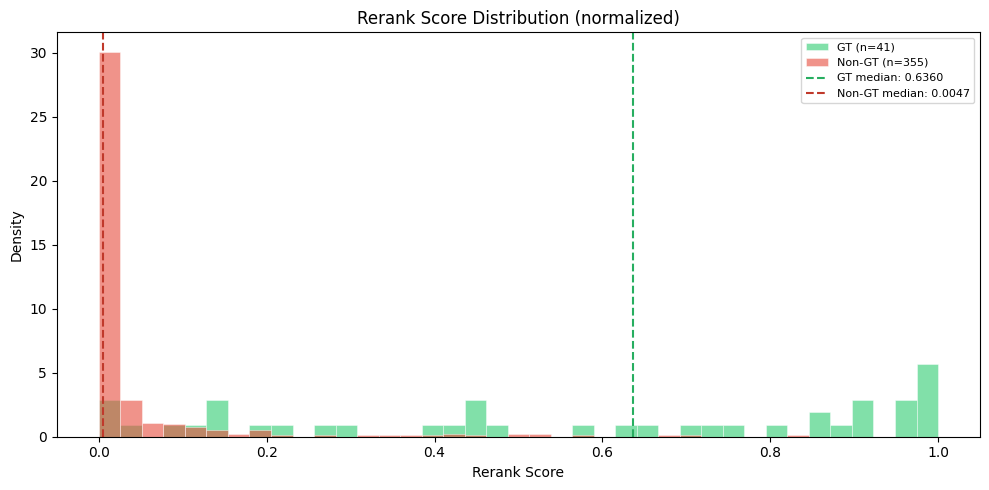

Saved: notebooks/phase2/figures/rerank_score_distribution.png


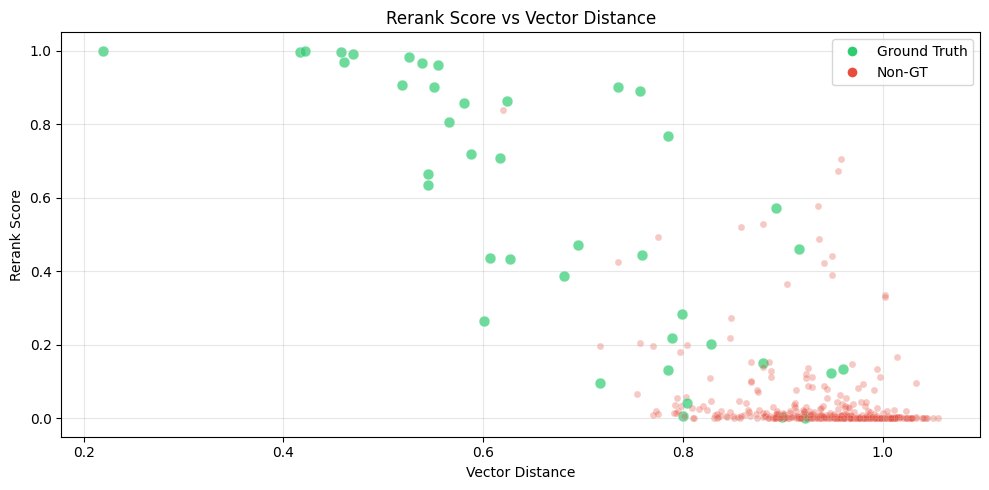

Saved: notebooks/phase2/figures/rerank_vs_distance_scatter.png

Per GT memory details (sorted by rerank score, descending):
  score=0.9999  dist=0.2194  mem_6f362f1d6808  (tc_review_4)
  score=0.9993  dist=0.4218  mem_788f1dcfbb8c  (tc_review_5)
  score=0.9965  dist=0.4162  mem_819630bee3db  (tc_review_11)
  score=0.9960  dist=0.4580  mem_80962cfd2f56  (tc_review_7)
  score=0.9919  dist=0.4692  mem_47f0c280ca8f  (tc_review_10)
  score=0.9822  dist=0.5257  mem_52c300d9d6dc  (tc_review_10)
  score=0.9689  dist=0.4604  mem_b09708770b0e  (tc_review_11)
  score=0.9676  dist=0.5386  mem_dec07d36f54c  (tc_review_8)
  score=0.9615  dist=0.5544  mem_bb5267a2e339  (tc_review_8)
  score=0.9067  dist=0.5191  mem_cc83c544db09  (tc_review_8)
  score=0.9021  dist=0.5505  mem_ddb0fa4f5e2c  (tc_review_1)
  score=0.9009  dist=0.7351  mem_4c83492fe063  (tc_review_9)
  score=0.8917  dist=0.7573  mem_3ee4e60637bc  (tc_review_6)
  score=0.8625  dist=0.6237  mem_3fe166a3b523  (tc_review_8)
  score=0.8581  di

In [8]:
# Cell 12 — Rerank Score Distribution & Threshold Sweep
import matplotlib.pyplot as plt
import numpy as np

FIGURES_DIR = Path("notebooks/phase2/figures")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

# Collect per-observation rerank scores (one entry per test_case x memory pair)
gt_scores_all = []       # (score, tc_id, mem_id)
non_gt_scores_all = []   # (score, tc_id, mem_id)

# Build per-experiment deduped rerank data (mirrors phase1 threshold analysis structure)
exp_reranked = []
for data in all_data:
    tc_id = data["test_case_id"]
    gt_ids = set(data.get("ground_truth", {}).get("memory_ids", []))
    # reranked_results contains ALL candidates sorted by rerank score
    reranked = data.get("reranked_results", [])
    scores_by_id = {r["id"]: r for r in reranked}

    exp_reranked.append({
        "tc_id": tc_id,
        "gt_ids": gt_ids,
        "scores_by_id": scores_by_id,
        "reranked": reranked,
    })

    for r in reranked:
        entry = (r["rerank_score"], tc_id, r["id"])
        if r.get("is_ground_truth"):
            gt_scores_all.append(entry)
        else:
            non_gt_scores_all.append(entry)

gt_scores = np.array([s for s, _, _ in gt_scores_all])
non_gt_scores = np.array([s for s, _, _ in non_gt_scores_all])

print(f"Experiments: {len(exp_reranked)} test cases")
print(f"GT observations:     {len(gt_scores)} (unique — each memory is GT in exactly 1 test case)")
print(f"Non-GT observations: {len(non_gt_scores)}")
print()
print(f"GT rerank score range:     [{gt_scores.min():.4f}, {gt_scores.max():.4f}]")
print(f"Non-GT rerank score range: [{non_gt_scores.min():.4f}, {non_gt_scores.max():.4f}]")
print(f"GT mean: {gt_scores.mean():.4f}, median: {np.median(gt_scores):.4f}")
print(f"Non-GT mean: {non_gt_scores.mean():.4f}, median: {np.median(non_gt_scores):.4f}")
print(f"Mean separation: {gt_scores.mean() - non_gt_scores.mean():.4f}")

# --- Figure 1: Score distribution histogram ---
fig1, ax1 = plt.subplots(figsize=(10, 5))
all_scores_combined = np.concatenate([gt_scores, non_gt_scores])
bins = np.linspace(all_scores_combined.min(), all_scores_combined.max(), 40)
ax1.hist(gt_scores, bins=bins, alpha=0.6, density=True,
         label=f"GT (n={len(gt_scores)})", color="#2ecc71", edgecolor="white", linewidth=0.5)
ax1.hist(non_gt_scores, bins=bins, alpha=0.6, density=True,
         label=f"Non-GT (n={len(non_gt_scores)})", color="#e74c3c", edgecolor="white", linewidth=0.5)
ax1.axvline(np.median(gt_scores), color="#27ae60", linestyle="--", linewidth=1.5,
            label=f"GT median: {np.median(gt_scores):.4f}")
ax1.axvline(np.median(non_gt_scores), color="#c0392b", linestyle="--", linewidth=1.5,
            label=f"Non-GT median: {np.median(non_gt_scores):.4f}")
ax1.set_xlabel("Rerank Score")
ax1.set_ylabel("Density")
ax1.set_title("Rerank Score Distribution (normalized)")
ax1.legend(fontsize=8)
fig1.tight_layout()
fig1.savefig(FIGURES_DIR / "rerank_score_distribution.png", dpi=200, bbox_inches="tight")
plt.show()
print(f"Saved: {FIGURES_DIR / 'rerank_score_distribution.png'}")

# --- Rerank score vs distance scatter ---
fig2, ax2 = plt.subplots(figsize=(10, 5))
for data in all_data:
    for r in data.get("reranked_results", []):
        color = "#2ecc71" if r.get("is_ground_truth") else "#e74c3c"
        alpha = 0.7 if r.get("is_ground_truth") else 0.3
        size = 60 if r.get("is_ground_truth") else 25
        ax2.scatter(r["distance"], r["rerank_score"], c=color, alpha=alpha, s=size, edgecolors="white", linewidth=0.3)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#2ecc71', markersize=8, label='Ground Truth'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#e74c3c', markersize=8, label='Non-GT'),
]
ax2.legend(handles=legend_elements)
ax2.set_xlabel("Vector Distance")
ax2.set_ylabel("Rerank Score")
ax2.set_title("Rerank Score vs Vector Distance")
ax2.grid(True, alpha=0.3)
fig2.tight_layout()
fig2.savefig(FIGURES_DIR / "rerank_vs_distance_scatter.png", dpi=200, bbox_inches="tight")
plt.show()
print(f"Saved: {FIGURES_DIR / 'rerank_vs_distance_scatter.png'}")

print(f"\nPer GT memory details (sorted by rerank score, descending):")
for score, tc_id, mid in sorted(gt_scores_all, key=lambda x: -x[0]):
    # Find the distance for this memory
    dist = 0
    for data in all_data:
        if data["test_case_id"] == tc_id:
            for r in data.get("reranked_results", []):
                if r["id"] == mid:
                    dist = r["distance"]
                    break
    print(f"  score={score:.4f}  dist={dist:.4f}  {mid}  ({tc_id})")

## Step 5b — Rerank Score Threshold Sweep

Sweep rerank score thresholds: accept all candidates with score >= threshold.
Higher threshold = stricter filtering (higher precision, lower recall).
Compare with Phase 1 distance threshold sweep.

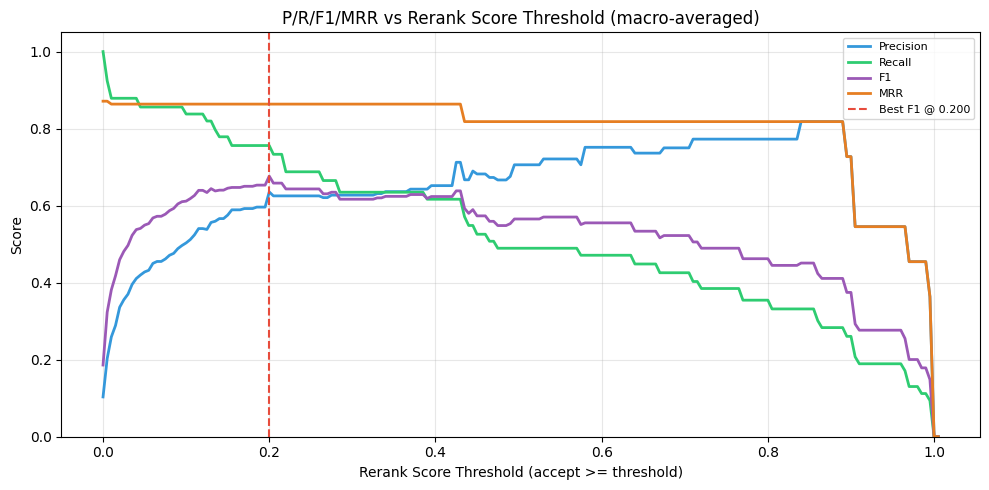

Saved: notebooks/phase2/figures/rerank_threshold_sweep.png

Optimal F1 threshold: 0.2000
  F1:        0.677
  Precision: 0.636
  Recall:    0.756
  MRR:       0.864

Threshold table (macro-averaged):
 Threshold  Precision   Recall       F1      MRR  Avg Accepted  Avg GT Kept
---------------------------------------------------------------------------
    0.0010      0.103    1.000    0.186    0.871          27.7          3.6
    0.0050      0.203    0.924    0.323    0.871          19.3          3.5
    0.0100      0.259    0.879    0.382    0.864          15.3          3.5
    0.0200      0.336    0.879    0.460    0.864          11.6          3.5
    0.0300      0.370    0.879    0.497    0.864          10.3          3.5
    0.0500      0.428    0.856    0.549    0.864           8.4          3.4
    0.0800      0.471    0.856    0.587    0.864           7.5          3.4
    0.1000      0.503    0.838    0.612    0.864           6.6          3.3
    0.1500      0.575    0.779    0.645 

In [9]:
# Cell 14 — Rerank Score Threshold Sweep
import numpy as np
import matplotlib.pyplot as plt

# Sweep rerank score thresholds (higher = stricter, opposite direction from distance)
all_scores_flat = np.concatenate([gt_scores, non_gt_scores])
sweep_thresholds = np.arange(0.0, max(all_scores_flat) + 0.01, 0.005)

sweep_p, sweep_r, sweep_f1, sweep_mrr = [], [], [], []

for t in sweep_thresholds:
    ps, rs, f1s, rrs = [], [], [], []
    for er in exp_reranked:
        # Accept candidates with rerank score >= threshold
        accepted = {r["id"] for r in er["reranked"] if r["rerank_score"] >= t}
        gt_accepted = len(accepted & er["gt_ids"])
        n_accepted = len(accepted)
        gt_count = len(er["gt_ids"])

        p = gt_accepted / n_accepted if n_accepted > 0 else 0.0
        r = gt_accepted / gt_count if gt_count > 0 else 0.0
        f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
        ps.append(p); rs.append(r); f1s.append(f1)

        # MRR: reciprocal rank of first GT hit in accepted results (sorted by rerank score desc)
        accepted_sorted = [r for r in er["reranked"] if r["rerank_score"] >= t]
        rr = 0.0
        for rank, r in enumerate(accepted_sorted, 1):
            if r["id"] in er["gt_ids"]:
                rr = 1.0 / rank
                break
        rrs.append(rr)

    sweep_p.append(np.mean(ps))
    sweep_r.append(np.mean(rs))
    sweep_f1.append(np.mean(f1s))
    sweep_mrr.append(np.mean(rrs))

sweep_p = np.array(sweep_p)
sweep_r = np.array(sweep_r)
sweep_f1 = np.array(sweep_f1)
sweep_mrr = np.array(sweep_mrr)

best_f1_idx = np.argmax(sweep_f1)
best_threshold = sweep_thresholds[best_f1_idx]

# --- Figure: P/R/F1/MRR vs rerank score threshold ---
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sweep_thresholds, sweep_p, label="Precision", color="#3498db", linewidth=2)
ax.plot(sweep_thresholds, sweep_r, label="Recall", color="#2ecc71", linewidth=2)
ax.plot(sweep_thresholds, sweep_f1, label="F1", color="#9b59b6", linewidth=2)
ax.plot(sweep_thresholds, sweep_mrr, label="MRR", color="#e67e22", linewidth=2)
ax.axvline(best_threshold, color="#e74c3c", linestyle="--", linewidth=1.5,
           label=f"Best F1 @ {best_threshold:.3f}")
ax.set_xlabel("Rerank Score Threshold (accept >= threshold)")
ax.set_ylabel("Score")
ax.set_title("P/R/F1/MRR vs Rerank Score Threshold (macro-averaged)")
ax.legend(fontsize=8)
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)
fig.tight_layout()
fig.savefig(FIGURES_DIR / "rerank_threshold_sweep.png", dpi=200, bbox_inches="tight")
plt.show()
print(f"Saved: {FIGURES_DIR / 'rerank_threshold_sweep.png'}")

print(f"\nOptimal F1 threshold: {best_threshold:.4f}")
print(f"  F1:        {sweep_f1[best_f1_idx]:.3f}")
print(f"  Precision: {sweep_p[best_f1_idx]:.3f}")
print(f"  Recall:    {sweep_r[best_f1_idx]:.3f}")
print(f"  MRR:       {sweep_mrr[best_f1_idx]:.3f}")

# Threshold table
print(f"\nThreshold table (macro-averaged):")
print(f"{'Threshold':>10} {'Precision':>10} {'Recall':>8} {'F1':>8} {'MRR':>8} {'Avg Accepted':>13} {'Avg GT Kept':>12}")
print("-" * 75)

# Pick representative thresholds around the interesting range
table_thresholds = sorted(set([0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.08, 0.10, 0.15, 0.20, 0.30, 0.50, round(best_threshold, 4)]))

for t in table_thresholds:
    idx = np.argmin(np.abs(sweep_thresholds - t))
    avg_accepted = np.mean([len([r for r in er["reranked"] if r["rerank_score"] >= t]) for er in exp_reranked])
    avg_gt_kept = np.mean([len({r["id"] for r in er["reranked"] if r["rerank_score"] >= t} & er["gt_ids"]) for er in exp_reranked])
    marker = " <--" if abs(t - best_threshold) < 0.003 else ""
    print(f"{t:>10.4f} {sweep_p[idx]:>10.3f} {sweep_r[idx]:>8.3f} {sweep_f1[idx]:>8.3f} {sweep_mrr[idx]:>8.3f} {avg_accepted:>13.1f} {avg_gt_kept:>12.1f}{marker}")

## Step 5c — Per-Experiment Impact at Optimal Rerank Threshold

Show how the optimal rerank score threshold performs on each test case.
Compare with Phase 1 distance threshold results.

In [10]:
# Cell 16 — Per-Experiment Impact at Optimal Rerank Threshold
import numpy as np

# Phase 1 optimal threshold from threshold analysis notebook
PHASE1_OPTIMAL_THRESHOLD = 0.76  # distance threshold

print(f"Per-experiment comparison at optimal thresholds:")
print(f"  Phase 1: distance <= {PHASE1_OPTIMAL_THRESHOLD}")
print(f"  Rerank:  score >= {best_threshold:.4f}")
print()

print(f"{'Test Case':<20} {'P1 F1':>7} {'Rk F1':>7} {'Delta':>7} {'P1 P':>6} {'Rk P':>6} {'P1 R':>6} {'Rk R':>6} {'P1 Acc':>7} {'Rk Acc':>7} {'GT':>4}")
print("-" * 100)

p1_f1s, rk_f1s = [], []
for er in exp_reranked:
    tc_id = er["tc_id"]
    gt_ids = er["gt_ids"]
    gt_count = len(gt_ids)

    # Phase 1: distance threshold
    p1_data = phase1_by_tc.get(tc_id, {})
    p1_best_distances = {}
    for qr in p1_data.get("queries", []):
        for r in qr.get("results", []):
            mid = r["id"]
            d = r.get("distance", float("inf"))
            if mid not in p1_best_distances or d < p1_best_distances[mid]:
                p1_best_distances[mid] = d
    p1_accepted = {mid for mid, d in p1_best_distances.items() if d <= PHASE1_OPTIMAL_THRESHOLD}
    p1_gt_hit = len(p1_accepted & gt_ids)
    p1_n = len(p1_accepted)
    p1_p = p1_gt_hit / p1_n if p1_n > 0 else 0
    p1_r = p1_gt_hit / gt_count if gt_count > 0 else 0
    p1_f1 = 2 * p1_p * p1_r / (p1_p + p1_r) if (p1_p + p1_r) > 0 else 0

    # Rerank: score threshold
    rk_accepted_list = [r for r in er["reranked"] if r["rerank_score"] >= best_threshold]
    rk_accepted_ids = {r["id"] for r in rk_accepted_list}
    rk_gt_hit = len(rk_accepted_ids & gt_ids)
    rk_n = len(rk_accepted_ids)
    rk_p = rk_gt_hit / rk_n if rk_n > 0 else 0
    rk_r = rk_gt_hit / gt_count if gt_count > 0 else 0
    rk_f1 = 2 * rk_p * rk_r / (rk_p + rk_r) if (rk_p + rk_r) > 0 else 0

    delta = rk_f1 - p1_f1
    marker = "+" if delta > 0.001 else "-" if delta < -0.001 else "="

    p1_f1s.append(p1_f1)
    rk_f1s.append(rk_f1)

    print(f"{tc_id:<20} {p1_f1:>7.3f} {rk_f1:>7.3f} {delta:>+6.3f}{marker} {p1_p:>6.1%} {rk_p:>6.1%} {p1_r:>6.1%} {rk_r:>6.1%} {p1_n:>7} {rk_n:>7} {gt_count:>4}")

    # Show missed GT for rerank
    rk_missed = gt_ids - rk_accepted_ids
    if rk_missed:
        for mid in sorted(rk_missed):
            # Find rerank score for this missed memory
            score = next((r["rerank_score"] for r in er["reranked"] if r["id"] == mid), None)
            score_str = f"score={score:.4f}" if score is not None else "NOT IN POOL"
            print(f"  {'':20} Missed: {mid} ({score_str})")

print("-" * 100)
avg_p1 = np.mean(p1_f1s)
avg_rk = np.mean(rk_f1s)
delta = avg_rk - avg_p1
print(f"{'AVERAGE':<20} {avg_p1:>7.3f} {avg_rk:>7.3f} {delta:>+6.3f}{'+'if delta>0 else '-' if delta<0 else '='}")

improved = sum(1 for p, r in zip(p1_f1s, rk_f1s) if r > p + 0.001)
same = sum(1 for p, r in zip(p1_f1s, rk_f1s) if abs(r - p) <= 0.001)
worse = sum(1 for p, r in zip(p1_f1s, rk_f1s) if r < p - 0.001)
print(f"\nReranking helped: {improved}/{len(p1_f1s)} | Same: {same}/{len(p1_f1s)} | Hurt: {worse}/{len(p1_f1s)}")

Per-experiment comparison at optimal thresholds:
  Phase 1: distance <= 0.76
  Rerank:  score >= 0.2000

Test Case              P1 F1   Rk F1   Delta   P1 P   Rk P   P1 R   Rk R  P1 Acc  Rk Acc   GT
----------------------------------------------------------------------------------------------------
tc_review_1            1.000   1.000 +0.000= 100.0% 100.0% 100.0% 100.0%       3       3    3
tc_review_10           1.000   0.533 -0.467- 100.0%  40.0% 100.0%  80.0%       5      10    5
                       Missed: mem_56746712ed52 (score=0.0962)
tc_review_11           0.857   0.750 -0.107- 100.0%  75.0%  75.0%  75.0%       3       4    4
                       Missed: mem_8df897f58579 (score=0.1511)
tc_review_2            0.000   0.000 +0.000=   0.0%   0.0%   0.0%   0.0%       1       0    2
                       Missed: mem_13c005e3e7f9 (score=0.0025)
                       Missed: mem_bd7e14fb86d7 (score=0.0077)
tc_review_3            0.667   0.667 +0.000= 100.0%  50.0%  50.0% 100.0%

In [11]:
# Cell 17 — Final Summary
import numpy as np

print("=" * 70)
print("RERANKING COMPARISON SUMMARY")
print("=" * 70)

print(f"\nPhase 1 run: {PHASE1_RUN.name}")
print(f"Test cases: {len(exp_reranked)}")
print(f"Reranker: {reranker.model_name}")

# Top-N comparison
print(f"\n--- Top-{RERANK_TOP_N} Comparison (distance vs rerank) ---")
avg_d_f1 = sum(r["distance_top_n_metrics"]["f1"] for r in all_results) / len(all_results)
avg_r_f1 = sum(r["rerank_top_n_metrics"]["f1"] for r in all_results) / len(all_results)
print(f"  Distance top-{RERANK_TOP_N} avg F1: {avg_d_f1:.3f}")
print(f"  Rerank top-{RERANK_TOP_N} avg F1:   {avg_r_f1:.3f}")
print(f"  Delta: {avg_r_f1 - avg_d_f1:+.3f}")

# Threshold comparison
print(f"\n--- Threshold Comparison (Phase 1 distance vs rerank score) ---")
print(f"  Phase 1 distance threshold {PHASE1_OPTIMAL_THRESHOLD}: avg F1 = {avg_p1:.3f}")
print(f"  Rerank score threshold {best_threshold:.4f}: avg F1 = {avg_rk:.3f}")
print(f"  Delta: {avg_rk - avg_p1:+.3f} ({(avg_rk - avg_p1)/avg_p1*100:+.1f}%)")

# Optimal rerank threshold details
print(f"\n--- Optimal Rerank Score Threshold ---")
print(f"  Threshold: {best_threshold:.4f}")
print(f"  F1:        {sweep_f1[best_f1_idx]:.3f}")
print(f"  Precision: {sweep_p[best_f1_idx]:.3f}")
print(f"  Recall:    {sweep_r[best_f1_idx]:.3f}")
print(f"  MRR:       {sweep_mrr[best_f1_idx]:.3f}")

print("=" * 70)

RERANKING COMPARISON SUMMARY

Phase 1 run: run_legacy
Test cases: 11
Reranker: BAAI/bge-reranker-v2-m3

--- Top-4 Comparison (distance vs rerank) ---
  Distance top-4 avg F1: 0.718
  Rerank top-4 avg F1:   0.645
  Delta: -0.073

--- Threshold Comparison (Phase 1 distance vs rerank score) ---
  Phase 1 distance threshold 0.76: avg F1 = 0.745
  Rerank score threshold 0.2000: avg F1 = 0.677
  Delta: -0.068 (-9.2%)

--- Optimal Rerank Score Threshold ---
  Threshold: 0.2000
  F1:        0.677
  Precision: 0.636
  Recall:    0.756
  MRR:       0.864
